## Step 1: Data Preparation & Initial Analysis

In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
import holidays

# Load data from an Excel file into a DataFrame
# - parse_dates=['Date']: Ensures that the 'Date' column is parsed as datetime objects
# - engine='openpyxl': Specifies the engine to use for reading the Excel file
df = pd.read_excel('../data/raw/Hotel_Revenue_Data.xlsx', parse_dates=['Date'], engine='openpyxl')

# Create temporal features directly in the main DataFrame
# Extract year, month, and day of the week from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
# Determine if the day is a weekend in the UAE (Friday and Saturday)
df['IsWeekend'] = df['Date'].dt.weekday >= 4

# Define all revenue centers as a list of strings
# This creates a list of revenue center names from 'RevenueCenter_1' to 'RevenueCenter_9'
all_revenue_centers = [f'RevenueCenter_{i}' for i in range(1, 10)]

# Create a complete index of all possible combinations of dates, meal periods, and revenue centers
# - date_range: Unique dates from the DataFrame
# - meal_periods: Unique meal periods from the DataFrame
date_range = df['Date'].unique()
meal_periods = df['MealPeriod'].unique()


# Create a multi-index that represents every possible combination of:
# - date_range: All unique dates in the dataset
# - meal_periods: All meal periods (Breakfast, Lunch, Dinner)
# - all_revenue_centers: All revenue centers (RevenueCenter_1 through RevenueCenter_9)
# This ensures we have a complete grid of all possible combinations, even if some don't exist in the data
# The resulting index will be used to identify missing data points and fill them with zeros
full_index = pd.MultiIndex.from_product(
    [date_range, meal_periods, all_revenue_centers],
    names=['Date', 'MealPeriod', 'RevenueCenterName']
)

# Create a base DataFrame with only the essential columns for merging
base_df = df[['Date', 'MealPeriod', 'RevenueCenterName', 'CheckTotal']]

# Create the complete DataFrame using merge instead of reindex
# - Reset the index of the DataFrame created from the multi-index
# - Merge with base_df to align data based on 'Date', 'MealPeriod', and 'RevenueCenterName'
# - how='left': Ensures all combinations in full_index are retained, filling missing data with NaN
df_complete = pd.DataFrame(index=full_index).reset_index()
print(df_complete)
df_complete = pd.merge(
    df_complete,
    base_df,
    on=['Date', 'MealPeriod', 'RevenueCenterName'],
    how='left'
)

# Fill missing values in 'CheckTotal' with 0
# This assumes that missing values in 'CheckTotal' imply zero revenue
df_complete['CheckTotal'] = df_complete['CheckTotal'].fillna(0)

# Add temporal features from unique dates to the complete DataFrame
# - drop_duplicates(): Ensures each date is unique in the date_features DataFrame
df_complete = pd.merge(
    df_complete,
    df[['Date', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']].drop_duplicates(),
    on='Date',
    how='left'
)

# Calculate daily totals by grouping the complete DataFrame
# - Group by 'Date', 'MealPeriod', 'RevenueCenterName', 'DayOfWeek', 'Month', 'Year'
# - Sum the 'CheckTotal' for each group to get daily totals
df_totals = df_complete.groupby(
    ['Date', 'MealPeriod', 'RevenueCenterName', 'DayOfWeek', 'Month', 'Year'],
    as_index=False
)['CheckTotal'].sum()

# Print the first 20 rows of the resulting DataFrame to verify the results
df_totals.head(20)

            Date MealPeriod RevenueCenterName
0     2023-04-18     Dinner   RevenueCenter_1
1     2023-04-18     Dinner   RevenueCenter_2
2     2023-04-18     Dinner   RevenueCenter_3
3     2023-04-18     Dinner   RevenueCenter_4
4     2023-04-18     Dinner   RevenueCenter_5
...          ...        ...               ...
13117 2024-04-04  BreakFast   RevenueCenter_5
13118 2024-04-04  BreakFast   RevenueCenter_6
13119 2024-04-04  BreakFast   RevenueCenter_7
13120 2024-04-04  BreakFast   RevenueCenter_8
13121 2024-04-04  BreakFast   RevenueCenter_9

[13122 rows x 3 columns]


,Date,MealPeriod,RevenueCenterName,DayOfWeek,Month,Year,CheckTotal
0,2023-01-01,BreakFast,RevenueCenter_1,6,1,2023,1499.4
1,2023-01-01,BreakFast,RevenueCenter_2,6,1,2023,35.0
2,2023-01-01,BreakFast,RevenueCenter_3,6,1,2023,0.0
3,2023-01-01,BreakFast,RevenueCenter_4,6,1,2023,0.0
4,2023-01-01,BreakFast,RevenueCenter_5,6,1,2023,21807.0
5,2023-01-01,BreakFast,RevenueCenter_6,6,1,2023,93.0
6,2023-01-01,BreakFast,RevenueCenter_7,6,1,2023,0.0
7,2023-01-01,BreakFast,RevenueCenter_8,6,1,2023,0.0
8,2023-01-01,BreakFast,RevenueCenter_9,6,1,2023,0.0
9,2023-01-01,Dinner,RevenueCenter_1,6,1,2023,4374.5


In [3]:
print(full_index)

MultiIndex([('2023-04-18',    'Dinner', 'RevenueCenter_1'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_2'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_3'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_4'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_5'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_6'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_7'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_8'),
            ('2023-04-18',    'Dinner', 'RevenueCenter_9'),
            ('2023-04-18',     'Lunch', 'RevenueCenter_1'),
            ...
            ('2024-04-04',     'Lunch', 'RevenueCenter_9'),
            ('2024-04-04', 'BreakFast', 'RevenueCenter_1'),
            ('2024-04-04', 'BreakFast', 'RevenueCenter_2'),
            ('2024-04-04', 'BreakFast', 'RevenueCenter_3'),
            ('2024-04-04', 'BreakFast', 'RevenueCenter_4'),
            ('2024-04-04', 'BreakFast', 'RevenueCenter_5'),
            ('2024-04-04

## Step 2: Zero Value Identification

In [4]:
import pandas as pd
import numpy as np
import holidays

def analyze_zeros(df_totals):
    print("\n" + "="*50)
    print("1. Normalizing meal period names...")
    # Standardize meal period names
    df_totals['MealPeriod'] = df_totals['MealPeriod'].str.strip().str.title()
    print(f"Unique meal periods: {df_totals['MealPeriod'].unique()}")
    
    # --- Data Validation ---
    print("\n" + "="*50)
    print("2. Data integrity checks...")
    required_columns = ['CheckTotal', 'RevenueCenterName', 'MealPeriod', 'Date']
    missing_cols = [col for col in required_columns if col not in df_totals.columns]
    if missing_cols:
        raise KeyError(f"Missing critical columns: {missing_cols}")
    print("✓ All required columns present")
    
    # --- Temporal Analysis ---
    print("\n" + "="*50)
    print("3. Performing temporal analysis...")
    
    # Create a zero-revenue indicator
    df_totals['is_zero'] = (df_totals['CheckTotal'] == 0).astype(int)
    
    # Calculate zero statistics by revenue center and meal period
    zero_analysis = df_totals.groupby(['RevenueCenterName', 'MealPeriod']).agg(
        zero_days=('is_zero', 'sum'),
        total_days=('is_zero', 'count'),
    ).reset_index()
    
    # Calculate zero percentage
    zero_analysis['zero_pct'] = zero_analysis['zero_days'] / zero_analysis['total_days'] * 100
    
    # --- Pivot Table Creation ---
    print("\n" + "="*50)
    print("4. Creating zero-revenue summary table...")
    
    # Create pivot table showing zero percentages
    pivot_table = zero_analysis.pivot_table(
        values='zero_pct',
        index='RevenueCenterName',
        columns='MealPeriod',
        fill_value=0
    )
    
    # Ensure all expected meal periods are present
    expected_meals = ['Breakfast', 'Lunch', 'Dinner']
    for meal in expected_meals:
        if meal not in pivot_table.columns:
            pivot_table[meal] = 0
    
    # Reorder columns
    pivot_table = pivot_table[expected_meals]
    
    # --- Key Observations ---
    print("\n" + "="*50)
    print("5. Key Observations:")
    
    # 1. Revenue centers with highest zero rates
    print("\nRevenue Centers with Highest Zero-Revenue Rates:")
    for meal in expected_meals:
        if meal in zero_analysis['MealPeriod'].unique():
            max_center = zero_analysis[zero_analysis['MealPeriod'] == meal].nlargest(1, 'zero_pct')
            name = max_center['RevenueCenterName'].values[0]
            pct = max_center['zero_pct'].values[0]
            print(f"- {meal}: {name} ({pct:.1f}% zero days)")
    
    # 2. Most reliable revenue centers
    print("\nMost Reliable Revenue Centers (Lowest Zero Rates):")
    for meal in expected_meals:
        if meal in zero_analysis['MealPeriod'].unique():
            min_center = zero_analysis[zero_analysis['MealPeriod'] == meal].nsmallest(1, 'zero_pct')
            name = min_center['RevenueCenterName'].values[0]
            pct = min_center['zero_pct'].values[0]
            print(f"- {meal}: {name} ({pct:.1f}% zero days)")
    
    # 3. Overall zero statistics
    overall_zero_pct = (df_totals['CheckTotal'] == 0).mean() * 100
    print(f"\nOverall Zero-Revenue Percentage: {overall_zero_pct:.1f}%")
    
    return zero_analysis, pivot_table


# =============================================================================
# Main Execution Pipeline
# =============================================================================
if __name__ == "__main__":
    # Load and preprocess data (from previous steps)
    # [Your data loading and preprocessing code here]
    
    print("\n" + "="*50)
    print("INITIALIZING ZERO-REVENUE ANALYSIS")
    print(f"Date range: {df_totals['Date'].min().date()} to {df_totals['Date'].max().date()}")
    print(f"Total records: {len(df_totals):,}")
    
    try:
        zero_analysis, zero_summary = analyze_zeros(df_totals)
        
        print("\n" + "="*50)
        print("ANALYSIS COMPLETE")
        
        print("\nZero Analysis Summary:")
        print(zero_analysis.sort_values(['MealPeriod', 'zero_pct'], ascending=[True, False]))
        
        print("\nZero-Revenue Percentage by Center and Meal Period:")
        print(zero_summary)
        
    except Exception as e:
        print("\n" + "="*50)
        print("❌ ANALYSIS FAILED")
        print(f"Error: {str(e)}")
        print("\nTroubleshooting Tips:")
        print("- Verify meal period values: should include Breakfast, Lunch, Dinner")
        print("- Check for missing columns in input data")
        print("- Ensure date format is correct")
        print("- Confirm revenue center names are consistent")


INITIALIZING ZERO-REVENUE ANALYSIS
Date range: 2023-01-01 to 2024-04-30
Total records: 13,122

1. Normalizing meal period names...
Unique meal periods: ['Breakfast' 'Dinner' 'Lunch']

2. Data integrity checks...
✓ All required columns present

3. Performing temporal analysis...

4. Creating zero-revenue summary table...

5. Key Observations:

Revenue Centers with Highest Zero-Revenue Rates:
- Breakfast: RevenueCenter_4 (100.0% zero days)
- Lunch: RevenueCenter_4 (100.0% zero days)
- Dinner: RevenueCenter_4 (99.8% zero days)

Most Reliable Revenue Centers (Lowest Zero Rates):
- Breakfast: RevenueCenter_5 (0.0% zero days)
- Lunch: RevenueCenter_3 (0.0% zero days)
- Dinner: RevenueCenter_1 (0.0% zero days)

Overall Zero-Revenue Percentage: 31.3%

ANALYSIS COMPLETE

Zero Analysis Summary:
   RevenueCenterName MealPeriod  zero_days  total_days    zero_pct
9    RevenueCenter_4  Breakfast        486         486  100.000000
21   RevenueCenter_8  Breakfast        447         486   91.975309
15

## Step 3: Islamic Calendar Alignment

In [5]:
import pandas as pd
from datetime import timedelta

def dubai_islamic_event_mapper(date):
    """Comprehensive mapper for Islamic periods and Dubai festivals affecting hotel revenue"""
    
    # Islamic Calendar Events
    ramadan_dates = {
        2023: (pd.to_datetime('2023-03-23'), pd.to_datetime('2023-04-20')),
        2024: (pd.to_datetime('2024-03-10'), pd.to_datetime('2024-04-08')),
        2025: (pd.to_datetime('2025-02-28'), pd.to_datetime('2025-03-29'))
    }
    
    eid_dates = {
        'Eid al-Fitr': {
            2023: pd.to_datetime('2023-04-21'),
            2024: pd.to_datetime('2024-04-09'),
            2025: pd.to_datetime('2025-03-30')
        },
        'Eid al-Adha': {
            2023: pd.to_datetime('2023-06-28'),
            2024: pd.to_datetime('2024-06-16'),
            2025: pd.to_datetime('2025-06-06')
        }
    }
    
    # Dubai Major Festivals & Events
    dubai_events = {
        'Dubai Shopping Festival': {
            2023: (pd.to_datetime('2023-12-15'), pd.to_datetime('2024-01-29')),
            2024: (pd.to_datetime('2024-12-06'), pd.to_datetime('2025-02-02')),
            2025: (pd.to_datetime('2025-12-06'), pd.to_datetime('2026-02-08'))
        },
        'Dubai Summer Surprises': {
            2023: (pd.to_datetime('2023-06-30'), pd.to_datetime('2023-09-03')),
            2024: (pd.to_datetime('2024-06-28'), pd.to_datetime('2024-09-01')),
            2025: (pd.to_datetime('2025-06-27'), pd.to_datetime('2025-08-31'))
        },
        'Dubai Food Festival': {
            2023: (pd.to_datetime('2023-02-23'), pd.to_datetime('2023-03-12')),
            2024: (pd.to_datetime('2024-02-22'), pd.to_datetime('2024-03-10')),
            2025: (pd.to_datetime('2025-02-20'), pd.to_datetime('2025-03-08'))
        },
        'GITEX Technology Week': {
            2023: (pd.to_datetime('2023-10-16'), pd.to_datetime('2023-10-20')),
            2024: (pd.to_datetime('2024-10-14'), pd.to_datetime('2024-10-18')),
            2025: (pd.to_datetime('2025-10-13'), pd.to_datetime('2025-10-17'))
        },
        'Dubai International Film Festival': {
            2023: (pd.to_datetime('2023-12-06'), pd.to_datetime('2023-12-13')),
            2024: (pd.to_datetime('2024-12-04'), pd.to_datetime('2024-12-11')),
            2025: (pd.to_datetime('2025-12-03'), pd.to_datetime('2025-12-10'))
        },
        'Dubai World Cup': {
            2023: pd.to_datetime('2023-03-25'),
            2024: pd.to_datetime('2024-03-30'),
            2025: pd.to_datetime('2025-03-29')
        },
        'Dubai Airshow': {
            2023: (pd.to_datetime('2023-11-13'), pd.to_datetime('2023-11-17')),
            2024: None,  # Biennial event
            2025: (pd.to_datetime('2025-11-17'), pd.to_datetime('2025-11-21'))
        },
        'Art Dubai': {
            2023: (pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-05')),
            2024: (pd.to_datetime('2024-02-28'), pd.to_datetime('2024-03-03')),
            2025: (pd.to_datetime('2025-02-26'), pd.to_datetime('2025-03-02'))
        },
        'Dubai Marathon': {
            2023: pd.to_datetime('2023-01-08'),
            2024: pd.to_datetime('2024-01-07'),
            2025: pd.to_datetime('2025-01-12')
        },
        'New Year Celebrations': {
            2023: pd.to_datetime('2023-01-01'),
            2024: pd.to_datetime('2024-01-01'),
            2025: pd.to_datetime('2025-01-01')
        }
    }
    
    # National UAE Events
    uae_national_events = {
        'UAE National Day': {
            2023: pd.to_datetime('2023-12-02'),
            2024: pd.to_datetime('2024-12-02'),
            2025: pd.to_datetime('2025-12-02')
        },
        'Flag Day': {
            2023: pd.to_datetime('2023-11-03'),
            2024: pd.to_datetime('2024-11-03'),
            2025: pd.to_datetime('2025-11-03')
        },
        'Commemoration Day': {
            2023: pd.to_datetime('2023-11-30'),
            2024: pd.to_datetime('2024-11-30'),
            2025: pd.to_datetime('2025-11-30')
        }
    }
    
    date = pd.to_datetime(date)
    year = date.year
    
    # ISLAMIC CALENDAR PROCESSING
    
    # Ramadan Period Analysis
    if year in ramadan_dates:
        start, end = ramadan_dates[year]
        
        # Pre-Ramadan preparation (3 weeks before)
        if date >= (start - timedelta(days=21)) and date < (start - timedelta(days=7)):
            return 'Pre-Ramadan-Early'
        elif date >= (start - timedelta(days=7)) and date < start:
            return 'Pre-Ramadan-Late'
        
        # During Ramadan - segmented periods
        elif date >= start and date <= end:
            ramadan_duration = (end - start).days
            days_into_ramadan = (date - start).days
            
            # First 10 days
            if days_into_ramadan <= 9:
                return 'Ramadan-First10Days'
            # Middle period
            elif days_into_ramadan <= ramadan_duration - 10:
                return 'Ramadan-Middle'
            # Last 10 days (Laylat al-Qadr period)
            else:
                return 'Ramadan-Last10Days'
        
        # Post-Ramadan periods
        elif date > end and date <= (end + timedelta(days=7)):
            return 'Post-Ramadan-Week1'
        elif date > (end + timedelta(days=7)) and date <= (end + timedelta(days=21)):
            return 'Post-Ramadan-Recovery'
    
    # Eid Holidays
    for eid_name, year_dates in eid_dates.items():
        if year in year_dates:
            eid_date = year_dates[year]
            
            if eid_name == 'Eid al-Fitr':
                # Pre-Eid (3 days before)
                if date >= (eid_date - timedelta(days=3)) and date < eid_date:
                    return 'Pre-Eid-Fitr'
                # During Eid (celebration period - 3 days)
                elif date >= eid_date and date <= (eid_date + timedelta(days=2)):
                    return 'Eid-Fitr'
                # Post-Eid recovery (1 week after)
                elif date > (eid_date + timedelta(days=2)) and date <= (eid_date + timedelta(days=9)):
                    return 'Post-Eid-Fitr'
            
            elif eid_name == 'Eid al-Adha':
                # Pre-Eid (5 days before - includes preparation)
                if date >= (eid_date - timedelta(days=5)) and date < eid_date:
                    return 'Pre-Eid-Adha'
                # During Eid (4 days celebration)
                elif date >= eid_date and date <= (eid_date + timedelta(days=3)):
                    return 'Eid-Adha'
                # Post-Eid (1 week after)
                elif date > (eid_date + timedelta(days=3)) and date <= (eid_date + timedelta(days=10)):
                    return 'Post-Eid-Adha'
    
    # DUBAI FESTIVALS & EVENTS
    
    # Dubai Shopping Festival (Major Tourism Period)
    if year in dubai_events['Dubai Shopping Festival']:
        start, end = dubai_events['Dubai Shopping Festival'][year]
        
        # Pre-DSF buildup (2 weeks before)
        if date >= (start - timedelta(days=14)) and date < start:
            return 'Pre-DSF'
        # During DSF
        elif date >= start and date <= end:
            return 'Dubai-Shopping-Festival'
        # Post-DSF period (1 week after)
        elif date > end and date <= (end + timedelta(days=7)):
            return 'Post-DSF'
    
    # Dubai Summer Surprises (Summer Tourism Boost)
    if year in dubai_events['Dubai Summer Surprises']:
        start, end = dubai_events['Dubai Summer Surprises'][year]
        
        # Pre-Summer event (1 week before)
        if date >= (start - timedelta(days=7)) and date < start:
            return 'Pre-Summer-Event'
        # During event
        elif date >= start and date <= end:
            return 'Dubai-Summer-Surprises'
        # Post-event (1 week after)
        elif date > end and date <= (end + timedelta(days=7)):
            return 'Post-Summer-Event'
    
    # Major Single-Day Events with 3-day impact windows
    single_day_events = [
        ('Dubai World Cup', dubai_events['Dubai World Cup']),
        ('Dubai Marathon', dubai_events['Dubai Marathon']),
        ('New Year Celebrations', dubai_events['New Year Celebrations']),
        ('UAE National Day', uae_national_events['UAE National Day']),
        ('Flag Day', uae_national_events['Flag Day']),
        ('Commemoration Day', uae_national_events['Commemoration Day'])
    ]
    
    for event_name, event_dates in single_day_events:
        if year in event_dates:
            event_date = event_dates[year]
            
            # Pre-event (2 days before)
            if date >= (event_date - timedelta(days=2)) and date < event_date:
                return f'Pre-{event_name.replace(" ", "-")}'
            # Event day
            elif date == event_date:
                return event_name.replace(' ', '-')
            # Post-event (2 days after)
            elif date > event_date and date <= (event_date + timedelta(days=2)):
                return f'Post-{event_name.replace(" ", "-")}'
    
    # Multi-day Events
    multi_day_events = [
        ('Dubai Food Festival', dubai_events['Dubai Food Festival']),
        ('GITEX Technology Week', dubai_events['GITEX Technology Week']),
        ('Dubai International Film Festival', dubai_events['Dubai International Film Festival']),
        ('Art Dubai', dubai_events['Art Dubai'])
    ]
    
    if year in dubai_events['Dubai Airshow'] and dubai_events['Dubai Airshow'][year]:
        multi_day_events.append(('Dubai Airshow', dubai_events['Dubai Airshow']))
    
    for event_name, event_dates in multi_day_events:
        if year in event_dates and event_dates[year] is not None:
            start, end = event_dates[year]
            
            # Pre-event (5 days before)
            if date >= (start - timedelta(days=5)) and date < start:
                return f'Pre-{event_name.replace(" ", "-")}'
            # During event
            elif date >= start and date <= end:
                return event_name.replace(' ', '-')
            # Post-event (3 days after)
            elif date > end and date <= (end + timedelta(days=3)):
                return f'Post-{event_name.replace(" ", "-")}'
    
    return 'Normal'

# Enhanced feature engineering function
def add_dubai_event_features(df):
    """Add comprehensive Dubai event features to the dataframe"""
    
    # Apply the enhanced mapper
    df['IslamicPeriod'] = df['Date'].apply(dubai_islamic_event_mapper)
    
    # Islamic Period Binary Flags
    df['IsRamadan'] = df['IslamicPeriod'].str.contains('Ramadan', na=False).astype(int)
    df['IsEid'] = df['IslamicPeriod'].str.contains('Eid', na=False).astype(int)
    df['IsPreRamadan'] = df['IslamicPeriod'].str.contains('Pre-Ramadan', na=False).astype(int)
    df['IsPostRamadan'] = df['IslamicPeriod'].str.contains('Post-Ramadan', na=False).astype(int)
    df['IsLast10Ramadan'] = (df['IslamicPeriod'] == 'Ramadan-Last10Days').astype(int)
    
    # Festival Binary Flags
    df['IsDSF'] = df['IslamicPeriod'].str.contains('DSF|Dubai-Shopping-Festival', na=False).astype(int)
    df['IsSummerEvent'] = df['IslamicPeriod'].str.contains('Summer', na=False).astype(int)
    df['IsWorldCup'] = df['IslamicPeriod'].str.contains('World-Cup', na=False).astype(int)
    df['IsNationalDay'] = df['IslamicPeriod'].str.contains('National-Day', na=False).astype(int)
    df['IsNewYear'] = df['IslamicPeriod'].str.contains('New-Year', na=False).astype(int)
    df['IsMarathon'] = df['IslamicPeriod'].str.contains('Marathon', na=False).astype(int)
    df['IsGITEX'] = df['IslamicPeriod'].str.contains('GITEX', na=False).astype(int)
    df['IsFilmFestival'] = df['IslamicPeriod'].str.contains('Film-Festival', na=False).astype(int)
    df['IsAirshow'] = df['IslamicPeriod'].str.contains('Airshow', na=False).astype(int)
    df['IsArtDubai'] = df['IslamicPeriod'].str.contains('Art-Dubai', na=False).astype(int)
    df['IsFoodFestival'] = df['IslamicPeriod'].str.contains('Food-Festival', na=False).astype(int)
    
    # Pre/Post Event Flags
    df['IsPreEvent'] = df['IslamicPeriod'].str.contains('Pre-', na=False).astype(int)
    df['IsPostEvent'] = df['IslamicPeriod'].str.contains('Post-', na=False).astype(int)
    
    # Tourism Intensity Levels
    high_tourism = ['Dubai-Shopping-Festival', 'Pre-DSF', 'New-Year-Celebrations', 
                   'Pre-New-Year-Celebrations', 'Dubai-World-Cup']
    medium_tourism = ['Dubai-Summer-Surprises', 'GITEX-Technology-Week', 'Dubai-Airshow']
    low_tourism = ['Ramadan-First10Days', 'Ramadan-Middle', 'Ramadan-Last10Days']
    
    df['TourismIntensity'] = 'Normal'
    df.loc[df['IslamicPeriod'].isin(high_tourism), 'TourismIntensity'] = 'High'
    df.loc[df['IslamicPeriod'].isin(medium_tourism), 'TourismIntensity'] = 'Medium'
    df.loc[df['IslamicPeriod'].isin(low_tourism), 'TourismIntensity'] = 'Low'
    
    # Revenue Impact Categories
    revenue_boost = ['Dubai-Shopping-Festival', 'New-Year-Celebrations', 'Dubai-World-Cup']
    revenue_neutral = ['GITEX-Technology-Week', 'Art-Dubai', 'Dubai-Marathon']
    revenue_decrease = ['Ramadan-First10Days', 'Ramadan-Middle', 'Eid-Fitr', 'Eid-Adha']
    
    df['RevenueImpact'] = 'Neutral'
    df.loc[df['IslamicPeriod'].isin(revenue_boost), 'RevenueImpact'] = 'Boost'
    df.loc[df['IslamicPeriod'].isin(revenue_decrease), 'RevenueImpact'] = 'Decrease'
    
    return df

# Apply to your dataframe
df_totals = add_dubai_event_features(df_totals)

# Fixed Analysis and Verification
print("Islamic Period Distribution:")
print(df_totals['IslamicPeriod'].value_counts().head(20))

print("\nTourism Intensity Distribution:")
print(df_totals['TourismIntensity'].value_counts())

print("\nRevenue Impact Categories:")
print(df_totals['RevenueImpact'].value_counts())

print("\nSample Dates with Classifications:")
sample_data = df_totals[['Date', 'IslamicPeriod', 'TourismIntensity', 'RevenueImpact', 
                        'IsRamadan', 'IsDSF', 'IsEid']].drop_duplicates().sort_values('Date')
print(sample_data.head(30))

print("\nEvent Flag Summary (Fixed):")
# Filter to only binary flags (integers) and exclude IsWeekend
event_flags = [col for col in df_totals.columns if col.startswith('Is') and col != 'IsWeekend']
# Ensure all are numeric before sorting
event_summary = df_totals[event_flags].select_dtypes(include=[int, float]).sum()
print(event_summary.sort_values(ascending=False))

# Additional summary for troubleshooting
print("\nColumn data types check:")
for col in event_flags:
    print(f"{col}: {df_totals[col].dtype}")

Islamic Period Distribution:
IslamicPeriod
Normal                       4563
Dubai-Summer-Surprises       1539
Pre-Ramadan-Early             756
Post-Ramadan-Recovery         756
Ramadan-First10Days           540
Ramadan-Last10Days            540
Ramadan-Middle                513
Dubai-Shopping-Festival       459
Pre-Ramadan-Late              378
Post-Ramadan-Week1            378
Pre-DSF                       378
Dubai-Food-Festival           189
Post-Eid-Adha                 189
Post-Summer-Event             189
Pre-Dubai-Food-Festival       162
Pre-GITEX-Technology-Week     135
Pre-Dubai-Airshow             135
Dubai-Airshow                 135
Pre-Eid-Adha                  135
GITEX-Technology-Week         135
Name: count, dtype: int64

Tourism Intensity Distribution:
TourismIntensity
Normal    8829
Medium    1809
Low       1593
High       891
Name: count, dtype: int64

Revenue Impact Categories:
RevenueImpact
Neutral     11448
Decrease     1161
Boost         513
Name: count, dtype:

In [9]:
df_totals.to_csv('dubai_totals_sample.csv', index=False)

In [1]:
import pandas as pd
import os

# Load the data
df = pd.read_csv('dubai_totals_sample.csv')

# Ensure the output directory exists
output_dir = 'revenue_center_data'
os.makedirs(output_dir, exist_ok=True)

# Group data by RevenueCenterName
grouped = df.groupby('RevenueCenterName')

# Iterate through each group and save to separate CSV file
for revenue_center, group in grouped:
    # Generate the filename based on the revenue center
    filename = os.path.join(output_dir, f"{revenue_center}_data.csv")
    
    # Save the group's data to the corresponding CSV file
    group.to_csv(filename, index=False)
    
    print(f"Saved data for {revenue_center} to {filename}")
    
print("All revenue center data has been saved successfully.")


Saved data for RevenueCenter_1 to revenue_center_data\RevenueCenter_1_data.csv
Saved data for RevenueCenter_2 to revenue_center_data\RevenueCenter_2_data.csv
Saved data for RevenueCenter_3 to revenue_center_data\RevenueCenter_3_data.csv
Saved data for RevenueCenter_4 to revenue_center_data\RevenueCenter_4_data.csv
Saved data for RevenueCenter_5 to revenue_center_data\RevenueCenter_5_data.csv
Saved data for RevenueCenter_6 to revenue_center_data\RevenueCenter_6_data.csv
Saved data for RevenueCenter_7 to revenue_center_data\RevenueCenter_7_data.csv
Saved data for RevenueCenter_8 to revenue_center_data\RevenueCenter_8_data.csv
Saved data for RevenueCenter_9 to revenue_center_data\RevenueCenter_9_data.csv
All revenue center data has been saved successfully.


## sample code to check how Each feature we extracted affect the distribution

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

df_sep = pd.read_csv('revenue_center_data/RevenueCenter_1_data.csv',
                 parse_dates=['Date'])


<Axes: xlabel='IsRamadan', ylabel='CheckTotal'>

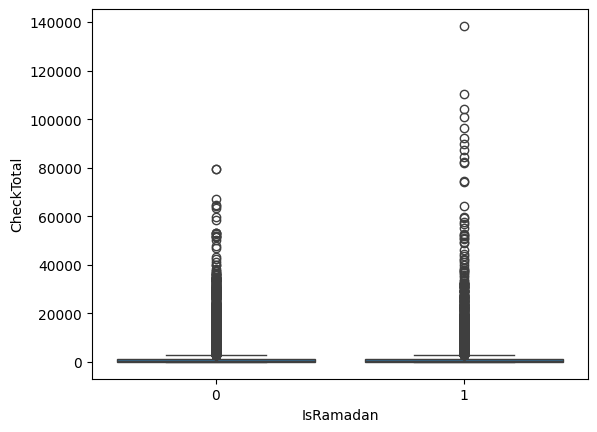

In [3]:
sns.boxplot(x='IsRamadan', y='CheckTotal', data=df)

In [4]:
df.groupby('IsRamadan')['CheckTotal'].mean()

IsRamadan
0    2371.756108
1    2806.840036
Name: CheckTotal, dtype: float64

<Axes: xlabel='Month', ylabel='DayOfWeek'>

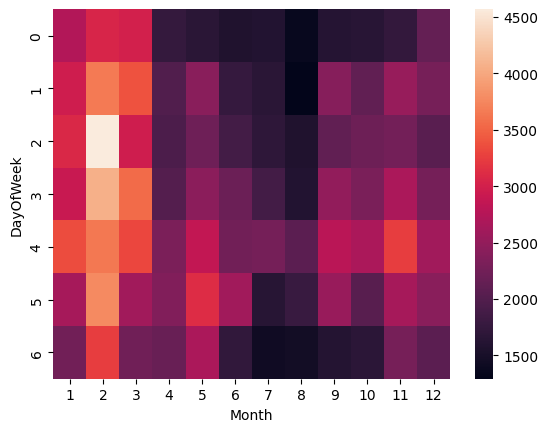

In [5]:
pivot = df.pivot_table('CheckTotal','DayOfWeek','Month'); sns.heatmap(pivot)